# Denoising methods comparison

In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

import matplotlib.pyplot as plt
import numpy as np
from tf_analysis import *
from analysis_utils import load_segment, load_dataset
from src.utils.config_manager import load_config
import pandas as pd
import seaborn as sns
from src.preprocessing.denoising import *

Load data

In [2]:
config = load_config(config_path='../config/config.yaml')
sample_rate = config["data"]["sample_rate"]

data_root = config["data"]["data_root"]
annotation_root = config["data"]["annotation_root"]

dataset = load_dataset(data_root, annotation_root, sample_rate)
#dataset_normalized = load_dataset(data_root, annotation_root, sample_rate, True)

date = '2026-01-10'

main_df = pd.DataFrame(dataset)
main_df = main_df[main_df['date'] == date]
#main_df_normalized = pd.DataFrame(dataset_normalized)
#main_df_normalized = main_df_normalized[main_df_normalized['date'] == date]

c:\Users\sokol\anaconda3\envs\vibroenv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\sokol\anaconda3\envs\vibroenv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Getting intresting features (small amount - big amount of data and denoising methods) - preliminary rejection of methods

In [8]:
def extract_light_features(signal, sample_rate):
    feats = {}

    feats.update(extract_time_features(signal))

    freqs, mag = compute_fft(signal, sample_rate)
    power = mag ** 2

    feats["fft_energy"] = np.sum(power)
    feats["fft_energy_low"] = np.sum(power[(freqs >= 0) & (freqs < 2000)])
    feats["fft_energy_mid"] = np.sum(power[(freqs >= 2000) & (freqs < 5000)])
    feats["fft_energy_high"] = np.sum(power[freqs >= 5000])

    feats["fft_max_mag"] = np.max(mag)

    mag_sum = np.sum(mag) + 1e-12

    feats["spectral_centroid"] = np.sum(freqs * mag) / mag_sum
    feats["spectral_bandwidth"] = np.sqrt(
        np.sum(((freqs - feats["spectral_centroid"]) ** 2) * mag) / mag_sum
    )
    feats["spectral_slope"] = spectral_slope(freqs, mag, 0, 2500)

    return feats


Get signals features (raw and denoised)

In [4]:
DENOISE_METHODS = {
    "wavelet": {
        "func": wavelet_denoise,
        "kwargs": {"wavelet": "db4", "level": 2, "threshold_factor": 0.04}
    },
    "spectral_sub": {
        "func": spectral_subtraction,
        "kwargs": {"fs": sample_rate, "n_fft": 256, "hop_length": 64}
    },
    "wiener": {
        "func": wiener_filter,
        "kwargs": {"mysize": 29}
    },
    "median": {
        "func": median_filter,
        "kwargs": {"kernel_size": 3}
    },
    "savgol": {
        "func": savgol_denoise,
        "kwargs": {"window_length": 51, "polyorder": 3}
    },
    "emd": {
        "func": emd_denoise,
        "kwargs": {"max_imf": 5, "drop_imf": 1}
    }
}

In [5]:
def get_method_deltas(data, sample_rate, method_name):
    rows = []

    for _, sample in data.iterrows():
        x = sample["signal"]
        x = x - np.mean(x)

        raw_feats = extract_light_features(x, sample_rate)
        method = DENOISE_METHODS[method_name]

        if method_name != "raw":
            x_d = method["func"](x, **method["kwargs"])
            den_feats = extract_light_features(x_d, sample_rate)
        else:
            den_feats = raw_feats

        row = {}
        for k in raw_feats:
            if k in ["spectral_slope", "spectral_bandwidth"]:
                row[k] = den_feats[k] - raw_feats[k]
            else:
                row[k] = 100 * (den_feats[k] - raw_feats[k]) / raw_feats[k]

        rows.append(row)

    return pd.DataFrame(rows)


In [6]:
summary = []

for method in DENOISE_METHODS.keys():
    print("Computing for: ", method)
    df_delta = get_method_deltas(main_df, sample_rate, method)
    summary.append({
        "method": method,

        "energy_loss_%": df_delta["energy"].median(),
        "rms_change_%": df_delta["rms"].median(),
        "crest_change_%": df_delta["crest_factor"].median(),
        "ptp_change_%": df_delta["ptp"].median(),
        "bandwidth_delta": df_delta["spectral_bandwidth"].median(),
        "slope_delta": df_delta["spectral_slope"].median(),
    })

summary_df = pd.DataFrame(summary)

Computing for:  wavelet
Computing for:  spectral_sub
Computing for:  wiener
Computing for:  median
Computing for:  savgol
Computing for:  emd


In [7]:
summary_df

,method,energy_loss_%,rms_change_%,crest_change_%,ptp_change_%,bandwidth_delta,slope_delta
0,wavelet,-0.028218,-0.014107,-0.793790,-0.747315,-158.032799,0.000177
1,spectral_sub,-98.396245,-87.336071,474.103590,-19.776859,219.213009,0.383610
2,wiener,-5.032720,-2.548837,1.947385,-1.012652,-0.766086,-0.040754
3,median,-0.053971,-0.026989,-3.401492,-3.586041,65.168617,-0.025229
4,savgol,-1.088899,-0.545938,-27.874831,-26.047724,-885.325460,-0.468326
5,emd,-0.079840,-0.039931,-3.385917,-3.645889,-918.579926,-0.025400


Temperature correlations

In [9]:
def compute_features_for_method(data, sample_rate, method_name):
    rows = []

    method = DENOISE_METHODS.get(method_name, None)

    for _, sample in data.iterrows():
        x = sample["signal"]
        x = x - np.mean(x)

        if method_name != "raw":
            x = method["func"](x, **method["kwargs"])

        feats = extract_light_features(x, sample_rate)
        feats["temperature"] = sample["temperature"]
        rows.append(feats)

    return pd.DataFrame(rows)

In [10]:
from scipy.stats import pearsonr, spearmanr

def compute_feature_correlations(df):
    results = []

    for col in df.columns:
        if col == "temperature":
            continue

        x = df[col].values
        y = df["temperature"].values

        if np.std(x) < 1e-8:
            continue

        p_r, _ = pearsonr(x, y)
        s_r, _ = spearmanr(x, y)

        results.append({
            "feature": col,
            "pearson_r": p_r,
            "spearman_r": s_r,
            "abs_pearson": abs(p_r),
            "abs_spearman": abs(s_r)
        })

    return pd.DataFrame(results).sort_values("abs_spearman", ascending=False)


In [12]:
all_results = []

for method_name in ["raw"] + list(DENOISE_METHODS.keys()):
    df_feats = compute_features_for_method(main_df, sample_rate, method_name)
    corr = compute_feature_correlations(df_feats)
    corr["method"] = method_name
    all_results.append(corr)

corr_all = pd.concat(all_results)

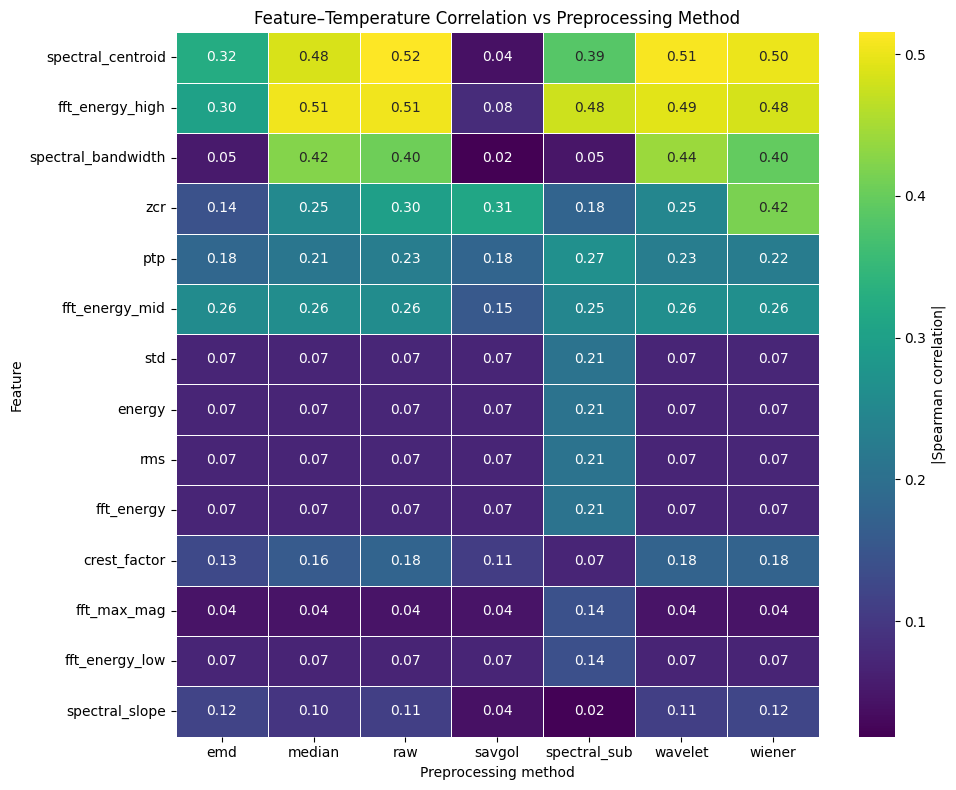

In [13]:
heatmap_data = corr_all.pivot(
    index="feature",
    columns="method",
    values="abs_spearman"
)

heatmap_data = heatmap_data.loc[
    heatmap_data.max(axis=1).sort_values(ascending=False).index
]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    linewidths=0.5,
    cbar_kws={"label": "|Spearman correlation|"}
)

plt.title("Feature–Temperature Correlation vs Preprocessing Method")
plt.xlabel("Preprocessing method")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()